In [46]:
import sys
import os
import contextlib
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
from torchvision import transforms
import shutil
import matplotlib as mpl
import torchvision.transforms.functional as TF

In [47]:
import kagglehub

# here we Download the dataset (it xan be exported from google drive if it was downloaded there)
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)

Path to dataset files: /home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [48]:
dataset_path=path+'/CCPD2019/ccpd_base/'
print(dataset_path)


/home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2/CCPD2019/ccpd_base/


Image: 0376436781609-100_67-192,431_468,556-483,570_220,507_192,414_455,477-0_0_24_9_30_30_27-60-24.jpg
Image: 0276987547893-92_87-160,467_453,572-468,575_167,549_160,458_461,484-0_0_20_25_7_33_26-134-118.jpg
Image: 00952586206897-90_86-311,564_482,636-494,636_321,629_304,563_477,570-0_3_14_26_31_26_27-110-17.jpg
Image: 0176245210728-98_77-335,326_538,424-545,425_352,390_340,319_533,354-0_0_22_13_31_33_26-94-15.jpg
Image: 0130495689655-87_91-225,421_416,504-414,485_238,499_237,436_413,422-0_0_16_8_30_30_25-116-26.jpg
Image: 01280651341-90_87-206,513_435,582-432,585_202,584_196,510_426,511-0_0_1_26_11_24_24-95-145.jpg
Image: 0312452107279-100_74-201,294_432,420-439,432_201,378_188,290_426,344-0_0_17_4_25_26_29-51-39.jpg



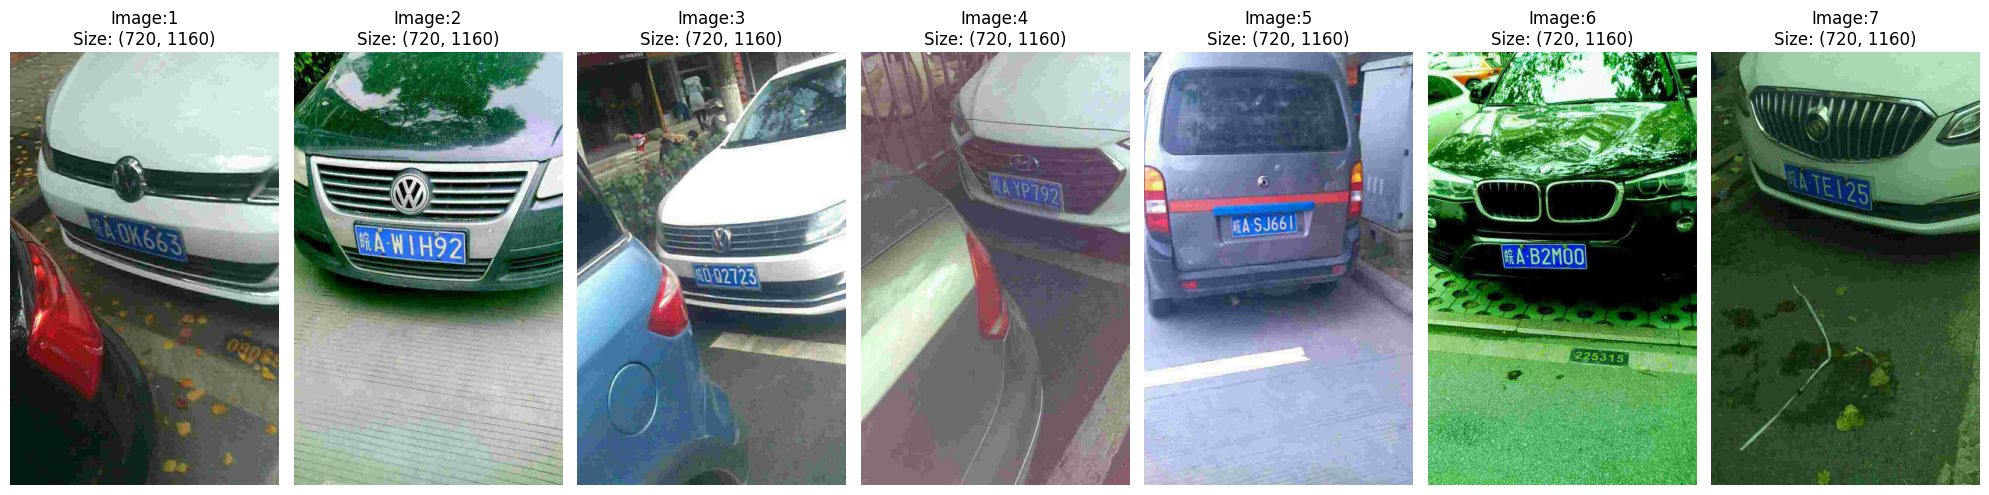

In [49]:
#visuilization some samples
def sample_images(dataset_path,num_of_images):
  image_files = random.sample([img for img in os.listdir(dataset_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))],num_of_images)
  plt.figure(figsize=(20, 6))

  for idx, img_file in enumerate(image_files):
      img_path = os.path.join(dataset_path, img_file)
      try:
            image = Image.open(img_path).convert("RGB")
            print(f"Image: {img_file}")
            plt.subplot(1, num_of_images, idx + 1)
            plt.imshow(image)
            plt.title(f"Image:{idx+1}\nSize: {image.size}")
            plt.axis("off")
      except Exception as e:
            print(f"Error{img_file}: {e}")
  print('')
  plt.tight_layout()
  plt.show()
sample_images(dataset_path,num_of_images=7)

In [50]:
#to extract the bonding boxe and the other from the image name
class CCPD_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size

        if self.transform:
            image = self.transform(baseimg.convert("RGB"))
        else:
            image = baseimg.convert("RGB")

        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        x_center = (x1 + x2) / 2 / orig_w
        y_center = (y1 + y2) / 2 / orig_h
        width = (x2 - x1) / orig_w
        height = (y2 - y1) / orig_h

        class_id = 0

        #used later on for the recognition part
        province_to_all_idx = {i: i for i in range(35)}
        alphabet_to_all_idx = {i: i for i in range(26)}
        ads_to_all_idx = {i: i for i in range(36)}

        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx.get(charaslist[0], 0)
        alphabetcharidx = alphabet_to_all_idx.get(charaslist[1], 0)
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx.get(idx, 0))
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx

        return img_name, (class_id, x_center, y_center, width, height)

In [51]:
!pip install ultralytics

import ultralytics
ultralytics.checks() #to verify the versions downloaded

Ultralytics 8.3.161 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Setup complete ✅ (16 CPUs, 7.7 GB RAM, 137.7/1006.9 GB disk)


In [7]:
def prepare_yolo_dataset(ccpd_dataset_path, output_root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure ratios sum to 1
    if not (train_ratio + val_ratio + test_ratio == 1.0):
        print("the sum is not equal to 1 to solve it i have changed the test ratio")
        test_ratio = 1.0 - train_ratio - val_ratio
        if test_ratio < 0:
            raise ValueError("Invalid ratios: train_ratio + val_ratio is greater than 1.")
        print(f"Adjusted ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

    # Create necessary directories used by yolo for images and labels
    # based on a specific architecture specified by the yolo
    train_img_dir = os.path.join(output_root_dir, 'images', 'train')
    train_lbl_dir = os.path.join(output_root_dir, 'labels', 'train')
    val_img_dir = os.path.join(output_root_dir, 'images', 'val')
    val_lbl_dir = os.path.join(output_root_dir, 'labels', 'val')
    test_img_dir = os.path.join(output_root_dir, 'images', 'test')
    test_lbl_dir = os.path.join(output_root_dir, 'labels', 'test')

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_lbl_dir, exist_ok=True)

    # extract all the images and shuffle them (HERE WE CAN ADD SOME ROTATION/ TRANSFORMATION FOR THE IMAGES)
    all_image_files = [f for f in os.listdir(ccpd_dataset_path) if f.endswith('.jpg')]
    random.shuffle(all_image_files)

    total_images = len(all_image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    test_size = total_images - train_size - val_size

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size : train_size + val_size]
    test_files = all_image_files[train_size + val_size : ]

    print(f"Total images found: {total_images}")
    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")
    print(f"Test images: {len(test_files)}")

    # Use the CCPD_Dataset to parse and generate labels
    temp_dataset = CCPD_Dataset(ccpd_dataset_path, all_image_files)

    # FUNCTION TO TRANSFORM THE DATASET LABES TO A SPECIFIC FORMAT LIKE TXT
    def process_split(files, img_output_dir, lbl_output_dir):
        count = 0
        for img_name in files:
            idx = temp_dataset.image_files.index(img_name)
            _, (class_id, x_center, y_center, width, height) = temp_dataset[idx]

            shutil.copy(os.path.join(ccpd_dataset_path, img_name), os.path.join(img_output_dir, img_name))

            label_filename = img_name.replace(".jpg", ".txt")
            with open(os.path.join(lbl_output_dir, label_filename), 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            count += 1
        return count

    print("Preparing training data...")
    processed_train = process_split(train_files, train_img_dir, train_lbl_dir)
    print(f"Finished preparing {processed_train} training samples.")

    print("Preparing validation data...")
    processed_val = process_split(val_files, val_img_dir, val_lbl_dir)
    print(f"Finished preparing {processed_val} validation samples.")

    print("Preparing test data...")
    processed_test = process_split(test_files, test_img_dir, test_lbl_dir)
    print(f"Finished preparing {processed_test} test samples.")

        # Create data.yaml file, which is used by the yolo to perform the training
    data_yaml_path = os.path.join(output_root_dir, 'data.yaml')
    data_yaml_content = f"""
path: {os.path.abspath(output_root_dir)}
train: images/train
val: images/val
test: images/test
nc: 1
names: ['car_plate']
"""
    with open(data_yaml_path, 'w') as f:
        f.write(data_yaml_content)
    print(f"Created data.yaml at {data_yaml_path}")



# here you should change the dataset path based on the one used in the computer/ colab
dataset_path = dataset_path
output_yolo_dir = '/content/yolo_ccpd_data' # Output directory for YOLO formatted data

if not os.path.exists(dataset_path):
    print(f"Error: Original CCPD dataset path not found: {dataset_path}")
    print("Please check your Google Drive mount and the exact path to your CCPD dataset folder.")
else:
    prepare_yolo_dataset(dataset_path, output_yolo_dir)



PermissionError: [Errno 13] Permission denied: '/content'

In [52]:
from ultralytics import YOLO

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# now let's train the yolo model
print("we start with training the YOLOv8 Model")

# Load a pre-trained YOLOv8n model (nano version, good starting point)
model = YOLO('yolov8n.pt')

# Training parameters
num_epochs = 2       # Number of training epochs. set to 2 for computational purposes
batch_size = 4       # Number of images per batch. also set to 4 due to computational purposes.
img_size = 640
device = 'cuda' if torch.cuda.is_available() else 'cpu' # remake sure of the use of the gpu

# set names for the project
project_name = 'yolov8_car_plate_detection'
run_name = 'ccpd_detection_run_3split_final'

print(f"Training on device: {device}")
print(f"Input image size: {img_size}x{img_size}")
print(f"Training run name: {run_name} under project: {project_name}")

results = model.train(data=os.path.join(output_yolo_dir, "data.yaml"),
                      epochs=num_epochs,
                      batch=batch_size,
                      imgsz=img_size,
                      device=device,
                      name=run_name,
                      project=project_name,
                      val=True)

print("done")


--- Step 5: Training the YOLOv8 Model ---
Training on device: cuda
Input image size: 640x640
Training run name: ccpd_detection_run_3split_final under project: yolov8_car_plate_detection
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_ccpd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mo

train: Scanning /content/yolo_ccpd_data/labels/train... 181955 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181955/181955 [09:55<00:00, 305.79it/s]


train: New cache created: /content/yolo_ccpd_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.3±1.7 ms, read: 11.2±3.3 MB/s, size: 71.6 KB)


val: Scanning /content/yolo_ccpd_data/labels/val... 55487 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55487/55487 [02:50<00:00, 325.25it/s]


val: New cache created: /content/yolo_ccpd_data/labels/val.cache
Plotting labels to yolov8_car_plate_detection/ccpd_detection_run_3split_final2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8_car_plate_detection/ccpd_detection_run_3split_final2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.592G      1.022     0.5116      1.026         10        640: 100%|██████████| 45489/45489 [1:39:55<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6936/6936 [10:37<00:00, 10.89it/s]


                   all      55487      55487      0.999          1      0.995      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.609G     0.9797     0.3871      1.014         11        640:  15%|█▌        | 6865/45489 [14:27<1:19:51,  8.06it/s]

In [ ]:
# Load trained detection model
detection_model = YOLO("yolov8_car_plate_detection/ccpd_detection_run_3split_final/weights/best.pt")

# Run inference on an image (or directory)
results = detection_model("/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test", conf=0.5, save=False, task='detect', stream=True)

# If you used stream=True, results is a generator; otherwise, it's a list
for result in results:
    # result.boxes contains all detected boxes
    for box in result.boxes:
        # Get coordinates
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # Bounding box (float)
        # Get confidence score
        conf = box.conf[0].item()
        # Get class id
        cls = int(box.cls[0].item())
        print(f"Box: {x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f} | Conf: {conf:.2f} | Class: {cls}")


image 1/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00229166666667-90_87-362,438_461,467-458,465_364,463_363,432_457,434-0_0_33_29_30_29_28-164-11.jpg: 640x416 1 car_plate, 8.4ms
Box: 361.0,429.6,457.3,466.1 | Conf: 0.74 | Class: 0
image 2/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00256944444445-92_87-224,566_311,607-317,602_220,603_218,564_315,563-0_0_24_21_30_29_28-110-8.jpg: 640x416 1 car_plate, 7.4ms
Box: 214.0,562.7,314.2,602.4 | Conf: 0.76 | Class: 0
image 3/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00283285440614-90_89-294,394_401,426-395,425_301,423_302,389_396,391-0_0_9_17_33_29_26-115-11.jpg: 640x416 1 car_plate, 8.1ms
Box: 298.4,388.6,394.5,424.1 | Conf: 0.72 | Class: 0
image 4/30000 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test/00290229885057-90_84-253,510_384,550-368,557_263,556_263,520_368,521-0_0_15_29_30_30_25-121-7.jpg: 640x416 1 car_plate, 7.4ms
Box: 25

KeyboardInterrupt: 

In [54]:
def crop_plate_from_detection(result, image_path, padding=5):
    # result of the yolo and the image paths
    img = Image.open(image_path).convert("RGB")
    w, h = img.size

    plates = []
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

        # Add optional padding
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(w, x2 + padding)
        y2 = min(h, y2 + padding)

        cropped = img.crop((x1, y1, x2, y2))
        plates.append(cropped)

    return plates  # List of PIL images

In [55]:
# resize in order to be the same size as the input declared for the pdlpr
recognition_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor()
])


In [56]:
# Suggested CCPD-Preprocess character lists:

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters):
    return ''.join([all_characters[i] for i in indices if i < len(all_characters) and i != pad_token_id])

char_to_idx = {char: idx for idx, char in enumerate(all_characters)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


Number of characters: 68


In [57]:
class CCPEDLicensePlateRecognitionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        image = Image.open(img_path).convert("RGB")

        fields = img_name.split('-')
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(charaslistdef, dtype=torch.long)

In [58]:
all_image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
dataset = CCPEDLicensePlateRecognitionDataset(dataset_path,all_image_files)
for i in range(5):
    img, label = dataset[i]
    if img is None or label is None:
        continue
    decoded = ''.join([idx_to_char[idx.item()] for idx in label])
    print(f"Sample {i+1}: {decoded}")

Sample 1: 皖A146U4
Sample 2: 皖AVP060
Sample 3: 皖AY0C05
Sample 4: 皖A098K6
Sample 5: 皖AAN692


In [59]:
# Create dataset
train_dataset = CCPEDLicensePlateRecognitionDataset(
    dataset_path=dataset_path,
    image_list=all_image_files,
    transform=recognition_transform
)

In [60]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_token_id):
    # Filter out invalid samples
    batch = [item for item in batch if item is not None and item[0] is not None]

    if not batch:
        return None, None

    images, labels = zip(*batch)
    images = torch.stack(images)  # (B, 3, 48, 144)

    # Pad labels to the same max length
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token_id)  # (B, T)

    return images, padded_labels

In [61]:
pad_token_id = char_to_idx["O"]

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id)
)

In [62]:
class Focus(nn.Module):
    #The focus model of the IGFE where it slice and concatenate
    #The usual shape is (B, C, H, W)
    def __init__(self, in_channels, out_channels):
        super(Focus, self).__init__()
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        top_left = x[..., ::2, ::2]
        top_right = x[..., ::2, 1::2]
        bottom_left = x[..., 1::2, ::2]
        bottom_right = x[..., 1::2, 1::2]
        x = torch.cat([top_left, top_right, bottom_left, bottom_right], dim=1)
        return self.act(self.bn(self.conv(x)))

class ConvDownSampling(nn.Module):
    # as the paper mentioned we need to use conv + BN + LeakyReLU with stride 2 for downsampling
    def __init__(self, in_channels, out_channels):
        super(ConvDownSampling, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.block(x)

class ResBlock(nn.Module):
    #the residual block
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.block(x) + x)

class IGFE(nn.Module):
    #here we concatenate the blocks as mentioned in the paper
    def __init__(self):
        super(IGFE, self).__init__()
        self.focus = Focus(3, 64)

        self.res1 = ResBlock(64)
        self.res2 = ResBlock(64)
        self.down1 = ConvDownSampling(64, 128)

        self.res3 = ResBlock(128)
        self.res4 = ResBlock(128)
        self.down2 = ConvDownSampling(128, 256)

        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)

    def forward(self, x):
        x = self.focus(x)        # (B, 64, 24, 72)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down1(x)        # (B, 128, 12, 36)
        x = self.res3(x)
        x = self.res4(x)
        x = self.down2(x)        # (B, 256, 6, 18)
        x = self.final_conv(x)   # (B, 512, 6, 18)
        return x



In [63]:
class PositionalEncoding(nn.Module):
    #add trainable parameters as positional embiddings
    def __init__(self, d_model, height, width):
        super(PositionalEncoding, self).__init__()
        self.positionalembeddings = nn.Parameter(torch.randn(1, d_model, height, width))  # (1, C, H, W)

    def forward(self, x):
        return x + self.positionalembeddings


In [64]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(d_model, d_model * 2, kernel_size=1)
        self.attn = nn.MultiheadAttention(d_model * 2, num_heads, batch_first=True)
        self.conv2 = nn.Conv2d(d_model * 2, d_model, kernel_size=1)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        #x is in the form (B, C, H, W)
        B, C, H, W = x.shape
        x = self.conv1(x)                      # (B, C*2, H, W)
        x_flat = x.flatten(2).permute(0, 2, 1) # (B, H*W, C*2)  HERE WE SHOULD PERFORM Permute to do attention block
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)  # (B, H*W, C*2)
        attn_out = attn_out.permute(0, 2, 1).view(B, C * 2, H, W)
        x = self.conv2(attn_out)               # (B, C, H, W)
        x = x + self.norm(x.flatten(2).transpose(1, 2)).transpose(1, 2).view(B, C, H, W)
        return x


In [65]:
#here we concatenate the pre prepared blocks
class Encoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3):
        super(Encoder, self).__init__()
        self.pos_enc = PositionalEncoding(d_model, height=6, width=18)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x)
        return x  # (B, 512, 6, 18)


In [66]:
class FeedForward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        return self.ff(x)


In [67]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = FeedForward(d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, targetSeq, memory, targetseq_mask=None):
        # Self-attention with mask
        local_targetSeq, _ = self.self_attn(targetSeq, targetSeq, targetSeq, attn_mask=targetseq_mask)
        targetSeq = self.norm1(targetSeq + local_targetSeq)

        # Cross-attention with encoder output (memory)
        local_targetSeq, _ = self.cross_attn(targetSeq, memory, memory)
        targetSeq = self.norm2(targetSeq + local_targetSeq)

        # Feedforward
        local_targetSeq = self.ff(targetSeq)
        targetSeq = self.norm3(targetSeq + local_targetSeq)

        return targetSeq


In [68]:
class ParallelDecoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=3, max_seq_len=18, num_classes=len(all_characters)):
        super().__init__()
        self.char_embed = nn.Embedding(num_classes, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        self.memory_proj = nn.Linear(d_model, d_model * 2)
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model * 2, num_heads) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(d_model * 2, num_classes)

    def forward(self, memory, tgt_seq, tgt_mask=None):
        seq_len = tgt_seq.size(1)
        tgt = self.char_embed(tgt_seq) + self.pos_embed[:, :seq_len, :]  # (B, T, d_model)
        memory_mean = memory.mean(dim=1, keepdim=False)  # (B, d_model)
        memory_expanded = memory_mean.unsqueeze(1).expand(-1, seq_len, -1)  # (B, T, d_model)
        memory_expanded_proj = self.memory_proj(memory_expanded)  # (B, T, d_model*2)
        concat = torch.cat([tgt, memory_expanded], dim=-1)  # (B, T, d_model*2)

        out = concat
        for layer in self.decoder_layers:
            out = layer(out, memory_expanded_proj, tgt_mask)  # <-- FIXED: use projected memory

        return self.output_proj(out)


In [69]:
class PDLPR(nn.Module):
    def __init__(self, num_classes, d_model=512, num_heads=8, num_layers=3, max_seq_len=18):
        super(PDLPR, self).__init__()
        self.igfe = IGFE()  # Feature extractor
        self.encoder = Encoder(d_model=d_model, num_heads=num_heads, num_layers=num_layers)
        self.decoder = ParallelDecoder(
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            max_seq_len=max_seq_len,
            num_classes=num_classes
        )
        self.max_seq_len = max_seq_len

    def forward(self, images, tgt_seq, tgt_mask=None):
        features = self.igfe(images)  # (B, 512, 6, 18)
        enc_out = self.encoder(features)  # (B, 512, 6, 18)
        B, C, H, W = enc_out.shape
        memory = enc_out.view(B, C, H * W).permute(0, 2, 1)  # (B, 108, 512)
        logits = self.decoder(memory, tgt_seq, tgt_mask)  # (B, max_seq_len, num_classes)
        return logits


In [70]:
num_classes = len(all_characters)
pad_token_id = char_to_idx["O"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = PDLPR(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [35]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n🟢 Starting Epoch {epoch + 1}/{num_epochs}")

    for step, (images, labels) in enumerate(train_loader):
        if images is None:
            continue

        images = images.to(device)
        labels = labels.to(device)

        decoder_input = labels[:, :-1]      # all tokens except last
        decoder_target = labels[:, 1:]      # all tokens except first

        logits = model(images, decoder_input)  # (B, T, num_classes)

        loss = F.cross_entropy(
            logits.reshape(-1, num_classes),
            decoder_target.reshape(-1),
            ignore_index=pad_token_id
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 10 == 0:
            print(f"  Step {step} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    torch.save(model.state_dict(), f"pdlpr_epoch_{epoch+1}.pth")



🟢 Starting Epoch 1/2
  Step 0 | Loss: 4.3502
  Step 10 | Loss: 3.0123
  Step 20 | Loss: 2.7309
  Step 30 | Loss: 2.4154
  Step 40 | Loss: 1.6587
  Step 50 | Loss: 1.0392
  Step 60 | Loss: 0.6888
  Step 70 | Loss: 0.6391
  Step 80 | Loss: 0.5935
  Step 90 | Loss: 0.5347
  Step 100 | Loss: 0.4862
  Step 110 | Loss: 0.5572
  Step 120 | Loss: 0.5079
  Step 130 | Loss: 0.5061
  Step 140 | Loss: 0.5224
  Step 150 | Loss: 0.5094
  Step 160 | Loss: 0.5623
  Step 170 | Loss: 0.4955
  Step 180 | Loss: 0.5252
  Step 190 | Loss: 0.4733
  Step 200 | Loss: 0.4718
  Step 210 | Loss: 0.4813
  Step 220 | Loss: 0.5491
  Step 230 | Loss: 0.5440


KeyboardInterrupt: 

In [22]:
pred = logits.argmax(dim=-1)

for i in range(min(2, pred.size(0))):  # Show 2 samples per batch
    pred_text = decode_sequence(pred[i].tolist(), all_characters)
    target_text = decode_sequence(decoder_target[i].tolist(), all_characters)
    print(f"\n🔍 Sample {i+1}")
    print("🟩 Prediction :", pred_text)
    print("🟥 GroundTruth:", target_text)



🔍 Sample 1
🟩 Prediction : 皖皖皖皖皖皖
🟥 GroundTruth: 皖陕云桂藏新

🔍 Sample 2
🟩 Prediction : 皖皖皖皖皖皖
🟥 GroundTruth: 皖津鄂甘宁甘


New training loop using actual bboxes evaluated by YOLO

In [71]:
#Set the training dataset path here:
train_dataset_path = '/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/train'

# Set the path to the trained model weights for inference yolo
yolo_weights_path = 'yolov8_car_plate_detection/ccpd_detection_run_3split_final/weights/best.pt'

# Load the trained YOLO model
detection_model = YOLO(yolo_weights_path)

Same dataset used before! But this time it crops plates directly into the __getitem__ method.

In [72]:
class CCPDCroppedPlates(torch.utils.data.Dataset):
    def __init__(self, image_dir, image_list, transform=None):
        self.image_dir = image_dir
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        # Just return the path and label info, not the cropped image
        fields = img_name.split('-')
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = [ads_to_all_idx[idx] for idx in charaslist[2:]]
        label = [provincecharidx, alphabetcharidx] + adscharidx
        return img_path, torch.tensor(label, dtype=torch.long)

In [30]:
def collate_fn_yolo(batch, yolo_model, transform, pad_token_id):
    # batch: list of (img_path, label)
    img_paths, labels = zip(*batch)
    # Call YOLO on all images in the batch at once
    with suppress_all_output():
        results = yolo_model(list(img_paths))
    images = []
    new_labels = []
    for i, result in enumerate(results):
        if len(result.boxes) == 0:
            continue  # skip if no detection
        box = result.boxes[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        image = Image.open(img_paths[i]).convert("RGB")
        cropped = image.crop((x1, y1, x2, y2))
        if transform:
            cropped = transform(cropped)
        images.append(cropped)
        new_labels.append(labels[i])
    if not images:
        return None, None
    images = torch.stack(images)
    padded_labels = pad_sequence(new_labels, batch_first=True, padding_value=pad_token_id)
    return images, padded_labels

In [67]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda b: collate_fn_yolo(b, detection_model, recognition_transform, pad_token_id)
)

In [68]:
val_dataset = CCPDCroppedPlates(
    image_dir='/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/val',
    image_list=os.listdir('/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/val'),
    transform=recognition_transform
)
test_dataset = CCPDCroppedPlates(
    image_dir='/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test',
    image_list=os.listdir('/home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/test'),
    transform=recognition_transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda b: collate_fn_yolo(b, detection_model, recognition_transform, pad_token_id)
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda b: collate_fn_yolo(b, detection_model, recognition_transform, pad_token_id)
)

Now training should focus perfectly only on the plate, and not on other distracting features.\
Setting up training loop.

In [69]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n🟢 Starting Epoch {epoch + 1}/{num_epochs}")

    for step, (images, labels) in enumerate(train_loader):
        if images is None:
            continue

        images = images.to(device)
        labels = labels.to(device)

        decoder_input = labels[:, :-1]      # all tokens except last
        decoder_target = labels[:, 1:]      # all tokens except first

        logits = model(images, decoder_input)  # (B, T, num_classes)

        loss = F.cross_entropy(
            logits.reshape(-1, num_classes),
            decoder_target.reshape(-1),
            ignore_index=pad_token_id
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 500 == 0:
            print(f"  Step {step} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    torch.save(model.state_dict(), f"pdlpr_epoch_{epoch+1}.pth")


🟢 Starting Epoch 1/2



image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/train/00705340038314-90_93-225,462_381,516-385,523_223,523_224,468_386,468-0_0_30_31_33_27_28-157-29.jpg: 640x416 1 car_plate, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/train/0182710727969-93_79-243,445_483,546-482,552_257,529_250,451_475,474-0_0_29_31_10_33_33-62-34.jpg: 640x416 1 car_plate, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/train/0239703065134-87_92-235,469_493,575-490,559_231,596_236,485_495,448-0_0_15_29_10_24_33-155-28.jpg: 640x416 1 car_plate, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/train/0251221264367-9

TypeError: type Tensor is not a supported Ultralytics prediction source type. 
See https://docs.ultralytics.com/modes/predict for supported source types.

In [33]:
# Visualize some predictions from the validation set
def visualize_predictions(dataset, model, num_samples=5):
    model.eval()
    mpl.rcParams['font.family'] = 'Noto Sans CJK'
    mpl.rcParams['axes.unicode_minus'] = False

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        if image is None or label is None:
            continue

        with torch.no_grad():
            image = image.unsqueeze(0).to(device)  # Add batch dimension
            logits = model(image, label.unsqueeze(0).to(device))  # Use the same label for input
            pred = logits.argmax(dim=-1)

        pred_text = decode_sequence(pred[0].tolist(), all_characters)
        true_text = decode_sequence(label.tolist(), all_characters)

        plt.figure(figsize=(6, 4))
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
        plt.title(f"Prediction: {pred_text}\nGround Truth: {true_text}")
        plt.axis('off')
        plt.show()

predictions = visualize_predictions(val_dataset, model, num_samples=5)


image 1/1 /home/dalex/AIRO_2024-2025/Training_data/yolo_ccpd_data/images/val/0159075670498-90_89-247,454_437,549-438,566_248,550_264,456_454,472-0_0_11_27_25_32_27-189-12.jpg: 640x416 1 car_plate, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 416)


AttributeError: 'list' object has no attribute 'unsqueeze'

YOLO isn't very compatible for usage with a detection model, and preprocessing with it takes a very long time and clogs system memory...

Enter SSD300/VGG16 detection model! That's gonna act as our detection backbone and feed high quality crops to the important part of the network, the PDLPR!

This is the dataset class as SSD needs for detection (it still works with the same CCPD pictures)

In [73]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)
dataset_path=path+'/CCPD2019/'

class CCPD_Dataset(Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path=os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size
        if self.transform:
            image = self.transform(Image.open(img_path).convert("RGB"))
        else:
            image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        # Target size after transform
        target_w, target_h = 300, 300

        # Scale bbox coordinates
        x1 = x1 * target_w / orig_w
        x2 = x2 * target_w / orig_w
        y1 = y1 * target_h / orig_h
        y2 = y2 * target_h / orig_h

        # Now turn the characters field into a tensor of indices (integers)
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx
        
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        charas = torch.tensor([charaslistdef], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "charas": charas
        }


        return image, target

Path to dataset files: /home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [74]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))

Initializing the dataloaders

Code reused from the SSD model framework in the other notebook since the setup of the training network will follow the same steps. Other than that, the model is the same as the [paper referenced for this project.](https://www.mdpi.com/1424-8220/24/9/2791)

In [75]:
# Check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# The augmented version
E2E_transform = transforms.Compose([
    transforms.Resize((340, 340)),
    transforms.RandomRotation(degrees=random.randint(0, 15)),
    transforms.CenterCrop((300, 300)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# The base version
no_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# This selects one of the two transformations at random for each image.
class RandomTransformSelector:
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        transform = random.choice(self.transforms_list)
        return transform(img)

random_transform = RandomTransformSelector([E2E_transform, no_transform])
train_dataset = CCPD_Dataset(dataset_path, train_list, transform=random_transform)
val_dataset = CCPD_Dataset(dataset_path, val_list, transform=no_transform)
test_dataset = CCPD_Dataset(dataset_path, test_list, transform=no_transform)

Using device: cuda


Instantiating the detection model and linkage to the recognition model:

In [76]:
# The detection model
detector = torchvision.models.detection.ssd300_vgg16(progress=True, num_classes=2, weights_backbone='DEFAULT', trainable_backbone_layers=0)
print(detector)
print(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [77]:
class SSD_PDLPR(nn.Module):
    def __init__(self, detector, recognizer, crop_size=(48, 144)):
        super().__init__()
        self.detector = detector
        self.recognizer = recognizer
        self.crop_size = crop_size
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def forward(self, images, targets=None):
        # images: (B, 3, H, W)
        # targets: list of dicts, each with 'boxes', 'labels', 'charas'
        if self.training and targets is not None:
            # Compute detection loss
            loss_dict = self.detector(images, targets)
            self.detector.eval()
            with torch.no_grad():
                outputs = self.detector(images)
            self.detector.train()
        else:
            loss_dict = {}
            outputs = self.detector(images)

        crops = []
        gt_charseqs = []
        all_boxes = []
        all_scores = []
        for i, output in enumerate(outputs):
            boxes = output['boxes']
            scores = output['scores']
            if len(scores) == 0:
                continue
            idx = torch.argmax(scores)
            box = boxes[idx]
            x1, y1, x2, y2 = box.int()
            image = images[i]
            _, H, W = image.shape
            x1 = max(0, min(x1.item(), W - 1))
            x2 = max(0, min(x2.item(), W))
            y1 = max(0, min(y1.item(), H - 1))
            y2 = max(0, min(y2.item(), H))
            if x2 <= x1 or y2 <= y1:
                crop_img = image
            else:
                crop_img = TF.crop(image, y1, x1, y2 - y1, x2 - x1)
            crop_img = TF.resize(crop_img, self.crop_size)
            crop_img = self.normalize(crop_img)
            crops.append(crop_img)
            all_boxes.append(boxes.detach().cpu())
            all_scores.append(scores.detach().cpu())
            if self.training and targets is not None:
                gt_charseqs.append(targets[i]['charas'][0])  # (seq_len,)

        if not crops:
            return None, None, {}, [], []

        crops = torch.stack(crops).to(device)
        if self.training and targets is not None:
            gt_charseqs = torch.stack(gt_charseqs).to(images.device)
        else:
            gt_charseqs = None

        if gt_charseqs is not None:
            decoder_input = gt_charseqs[:, :-1]
        else:
            batch_size = crops.size(0)
            seq_len = 7
            start_token = char_to_idx["O"]
            decoder_input = torch.full((batch_size, seq_len), start_token, dtype=torch.long, device=crops.device)
        logits = self.recognizer(crops, decoder_input)

        # Return boxes and scores as lists of tensors (one per image)
        return logits, gt_charseqs, loss_dict, all_boxes, all_scores

In [78]:
recognizer = PDLPR(num_classes=len(all_characters)).to(device)
recognizer.to(device)
detector.to(device)

model = SSD_PDLPR(detector, recognizer).to(device)
# Load the whole model weights
model_weights_path = 'ssd_pdlpr_epoch_3.pth'
model.load_state_dict(torch.load(model_weights_path, map_location=device))

<All keys matched successfully>

In [79]:
# A custom collate function is needed because, without it, the DataLoader outputs one target for a batch of images
def collate_dicttargets(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

In [80]:
def inspect_batch(train_loader, all_characters, idx_to_char):
    batch = next(iter(train_loader))
    images, targets = batch
    print(f"Batch size: {len(images)}")
    for i in range(min(3, len(images))):  # Show up to 3 samples
        img = images[i]
        target = targets[i]
        # Show image
        img_np = img.permute(1,2,0).cpu().numpy()
        img_np = (img_np * 0.5 + 0.5).clip(0,1)
        plt.figure(figsize=(4,4))
        plt.imshow(img_np)
        # Draw bbox
        box = target['boxes'][0].cpu().numpy()
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
        plt.title("Sample image with GT bbox")
        plt.axis('off')
        plt.show()
        # Print char sequence
        char_indices = target['charas'][0].cpu().tolist()
        char_str = ''.join([idx_to_char[idx] for idx in char_indices])
        print(f"GT char indices: {char_indices}")
        print(f"GT char string: {char_str}")

Batch size: 16


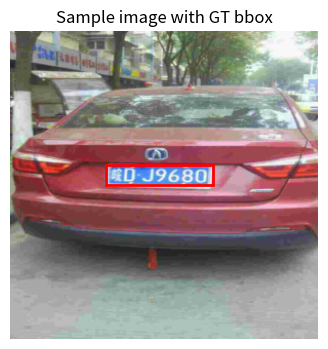

GT char indices: [0, 36, 41, 66, 63, 65, 57]
GT char string: 皖DJ9680


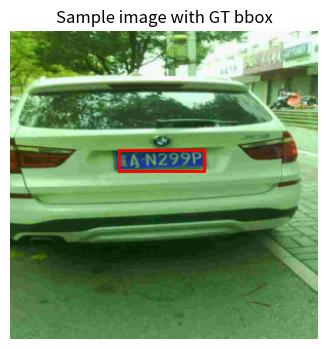

GT char indices: [0, 33, 45, 59, 66, 66, 46]
GT char string: 皖AN299P


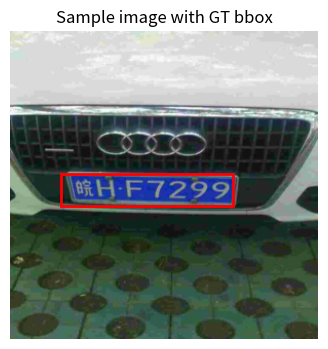

GT char indices: [0, 40, 38, 64, 59, 66, 66]
GT char string: 皖HF7299

🟢 Starting Epoch 1/5
  Step 0 | Loss: 2.8555
  Step 500 | Loss: 3.2569


KeyboardInterrupt: 

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_dicttargets, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_dicttargets)
inspect_batch(train_loader, all_characters, idx_to_char)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n🟢 Starting Epoch {epoch + 1}/{num_epochs}")

    for step, (images, targets) in enumerate(train_loader):
        if images is None or targets is None:
            continue

        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        logits, gt_charseqs, loss_dict = model(images, targets)[:3]

        if logits is not None and gt_charseqs is not None:
            decoder_input = gt_charseqs[:, :-1]
            decoder_target = gt_charseqs[:, 1:]
            rec_loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                decoder_target.reshape(-1),
                ignore_index=pad_token_id
            )
            total_batch_loss = sum(loss_dict.values()) + rec_loss
        else:
            total_batch_loss = sum(loss_dict.values())

        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()
        total_loss += total_batch_loss.item()
        if step % 500 == 0:
            print(f"  Step {step} | Loss: {sum(loss_dict.values()).item():.4f}")

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    torch.save(model.state_dict(), f"ssd_pdlpr_epoch_{epoch+1}.pth")

Testing the model on one picture at a time:

In [81]:
# Function needed to show the predicted bounding boxes and the ground truth box
def show_bounding_box_with_gt(image, boxes, scores=None, top_k=None, gt_box=None):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5).clip(0, 1)
    plt.imshow(image)
    
    cmap = plt.colormaps.get_cmap('plasma')
    
    if scores is not None:
        if top_k is not None:
            indices = np.argsort(scores)[-top_k:][::-1]
            boxes = boxes[indices]
            scores = scores[indices]
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
        colors = cmap(norm_scores)
        
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i][:3] if scores is not None else 'red'
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2))
        plt.text(x1, y1 - 5, str(i + 1), color='white', fontsize=12, weight='bold', 
                 bbox=dict(facecolor=color, edgecolor='none', pad=1, alpha=0.7))
    
    # Draw ground truth box in green
    if gt_box is not None:
        x1, y1, x2, y2 = gt_box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='lime', linewidth=2, linestyle='--'))
        plt.text(x1, y1 - 15, "GT", color='lime', fontsize=12, weight='bold', 
                 bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.7))
    
    if scores is not None and len(scores) > 0:
        norm = mpl.colors.Normalize(vmin=scores.min(), vmax=scores.max())
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
        cbar.set_label('Confidence Score') 
    
    plt.suptitle(f'Predicted Bounding Boxes (Showing best {len(boxes)} boxes)')   
    plt.axis('off')
    plt.show()

# ...and the IoU function    
def IoU(pred_bbox, target_bbox):
    predbbox_length = pred_bbox[0][2] - pred_bbox[0][0]
    predbbox_height = pred_bbox[0][3] - pred_bbox[0][1]
    targetbbox_length = target_bbox[0][2] - target_bbox[0][0]
    targetbbox_height = target_bbox[0][3] - target_bbox[0][1]

    intersectionarea = torch.max(torch.tensor(0), torch.min(pred_bbox[0][2], target_bbox[0][2]) - torch.max(pred_bbox[0][0], target_bbox[0][0])) * torch.max(torch.tensor(0), torch.min(pred_bbox[0][3], target_bbox[0][3]) - torch.max(pred_bbox[0][1], target_bbox[0][1]))
    unionarea = predbbox_length * predbbox_height + targetbbox_length * targetbbox_height - intersectionarea
    iou = intersectionarea / unionarea
    return iou

torch.Size([1, 7, 68]) {}


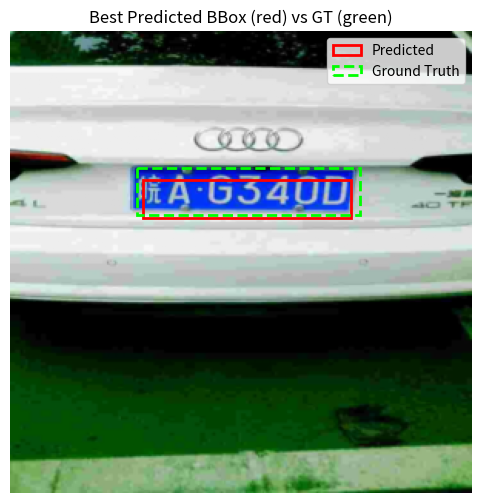

🟩 Ground Truth Sequence: 皖AG340D
🟥 Predicted Sequence  : AAAAAAA


In [67]:
model.load_state_dict(torch.load('ssd_pdlpr_epoch_3.pth', map_location=device))
model.eval()
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'
mpl.rcParams['axes.unicode_minus'] = False

with torch.no_grad():
    # Get a random image from the validation set
    image, target = val_dataset[random.randint(0, len(val_dataset)-1)]
    image = image.to(device)
    logits, gt_charseqs, loss_dict, all_boxes, all_scores = model(image.unsqueeze(0))
    if logits is None:
        print("No bounding box detected for this image.")
    else:
        print(logits.shape, loss_dict)
        # Get predicted boxes and scores
        boxes = all_boxes[0].cpu().numpy()
        scores = all_scores[0].cpu().numpy()
        gt_box = target['boxes'][0].cpu().numpy()

        # Show best predicted bbox vs GT
        best_idx = scores.argmax()
        best_box = boxes[best_idx]
        plt.figure(figsize=(6,6))
        img_np = image.cpu().permute(1,2,0).numpy()
        img_np = (img_np * 0.5 + 0.5).clip(0,1)
        plt.imshow(img_np)
        # Draw predicted box
        x1, y1, x2, y2 = best_box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2, label='Predicted'))
        # Draw GT box
        gx1, gy1, gx2, gy2 = gt_box
        plt.gca().add_patch(plt.Rectangle((gx1, gy1), gx2-gx1, gy2-gy1, fill=False, color='lime', linewidth=2, linestyle='--', label='Ground Truth'))
        plt.legend(['Predicted', 'Ground Truth'])
        plt.title('Best Predicted BBox (red) vs GT (green)')
        plt.axis('off')
        plt.show()

        # Show predicted vs GT character sequence
        indices = target["charas"].squeeze(0).tolist()
        gt_str = decode_sequence(indices, all_characters)
        pred_indices = logits.argmax(dim=2)[0].cpu().tolist()
        pred_str = decode_sequence(pred_indices, all_characters)
        print(f"🟩 Ground Truth Sequence: {gt_str}")
        print(f"🟥 Predicted Sequence  : {pred_str}")

Final attempt: Training PDLPR only on GT bboxes,

In [87]:
# --- 1. Dataset: Crop plates using GT boxes ---

class CCPD_GT_CroppedPlates(torch.utils.data.Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.dataset_path = dataset_path
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.dataset_path, img_name)
        image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))
        # Crop plate using GT box
        cropped = image.crop((x1, y1, x2, y2))
        if self.transform:
            cropped = self.transform(cropped)
        # Prepare label as before
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = [ads_to_all_idx[idx] for idx in charaslist[2:]]
        label = [provincecharidx, alphabetcharidx] + adscharidx
        return cropped, torch.tensor(label, dtype=torch.long)

# --- 2. DataLoader ---

train_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=train_list,  # Use your split
    transform=recognition_transform
)
val_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=val_list,
    transform=recognition_transform
)

from torch.nn.utils.rnn import pad_sequence

def collate_fn_gt(batch, pad_token_id):
    batch = [item for item in batch if item is not None and item[0] is not None]
    if not batch:
        return None, None
    images, labels = zip(*batch)
    images = torch.stack(images)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token_id)
    return images, padded_labels

pad_token_id = char_to_idx["O"]
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)

# --- 3. Training loop (recognizer only) ---

model = PDLPR(num_classes=len(all_characters)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\n🟢 Starting Epoch {epoch + 1}/{num_epochs}")
    for step, (images, labels) in enumerate(train_loader):
        if images is None:
            continue
        images = images.to(device)
        labels = labels.to(device)
        start_token = torch.full((labels.size(0), 1), pad_token_id, dtype=torch.long, device=labels.device)
        decoder_input = torch.cat([start_token, labels[:, :-1]], dim=1)
        decoder_target = labels
        logits = model(images, decoder_input)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            decoder_target.reshape(-1),
            ignore_index=pad_token_id
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if step % 300 == 0:
            print(f"  Step {step} | Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    torch.save(model.state_dict(), f"pdlpr_gtcrop_epoch_{epoch+1}.pth")

    # --- Validation loop ---
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            if val_images is None:
                continue
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            start_token = torch.full((val_labels.size(0), 1), pad_token_id, dtype=torch.long, device=val_labels.device)
            decoder_input = torch.cat([start_token, val_labels[:, :-1]], dim=1)
            decoder_target = val_labels
            logits = model(val_images, decoder_input)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                decoder_target.reshape(-1),
                ignore_index=pad_token_id
            )
            val_loss += loss.item()
            num_batches += 1

            # Optionally print a few predictions
            if num_batches == 1:
                pred = logits.argmax(dim=-1)
                for i in range(min(2, pred.size(0))):
                    pred_text = decode_sequence(pred[i].tolist(), all_characters)
                    target_text = decode_sequence(decoder_target[i].tolist(), all_characters)
                    print(f"\n[VAL] Sample {i+1}")
                    print("🟩 Prediction :", pred_text)
                    print("🟥 GroundTruth:", target_text)

    avg_val_loss = val_loss / max(1, num_batches)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
    
    


🟢 Starting Epoch 1/5
  Step 0 | Loss: 4.3764
  Step 300 | Loss: 0.3794
  Step 600 | Loss: 0.1990
  Step 900 | Loss: 0.0295
  Step 1200 | Loss: 0.0501
  Step 1500 | Loss: 0.0332
  Step 1800 | Loss: 0.0145
  Step 2100 | Loss: 0.0638
  Step 2400 | Loss: 0.0019
  Step 2700 | Loss: 0.0440
  Step 3000 | Loss: 0.0027
Epoch 1 - Loss: 0.1424

[VAL] Sample 1
🟩 Prediction : 皖AB1120
🟥 GroundTruth: 皖AB112D

[VAL] Sample 2
🟩 Prediction : 皖APV930
🟥 GroundTruth: 皖APV930
Epoch 1 - Validation Loss: 0.0205

🟢 Starting Epoch 2/5
  Step 0 | Loss: 0.0143
  Step 300 | Loss: 0.0027
  Step 600 | Loss: 0.0225
  Step 900 | Loss: 0.0061
  Step 1200 | Loss: 0.0112
  Step 1500 | Loss: 0.0124
  Step 1800 | Loss: 0.0181
  Step 2100 | Loss: 0.0015
  Step 2400 | Loss: 0.0060
  Step 2700 | Loss: 0.0021
  Step 3000 | Loss: 0.0005
Epoch 2 - Loss: 0.0138

[VAL] Sample 1
🟩 Prediction : 皖AB112D
🟥 GroundTruth: 皖AB112D

[VAL] Sample 2
🟩 Prediction : 皖APV930
🟥 GroundTruth: 皖APV930
Epoch 2 - Validation Loss: 0.0143

🟢 Starting 

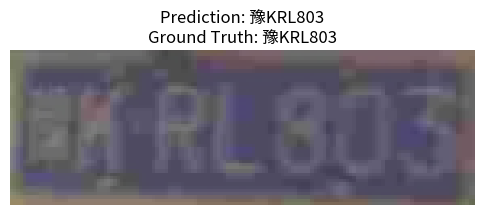

Sample 1 - Prediction: 豫KRL803, Ground Truth: 豫KRL803


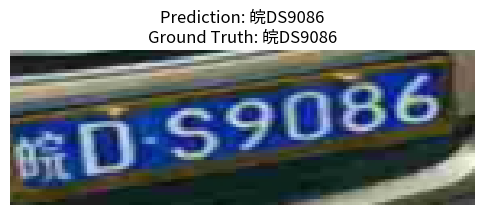

Sample 2 - Prediction: 皖DS9086, Ground Truth: 皖DS9086


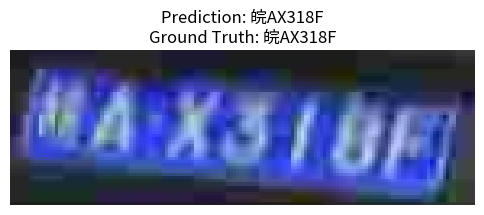

Sample 3 - Prediction: 皖AX318F, Ground Truth: 皖AX318F


In [116]:
# --- Test set using GT-cropped plates ---
test_dataset = CCPD_GT_CroppedPlates(
    dataset_path=dataset_path,
    image_list=test_list,  # Use your test split
    transform=recognition_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    collate_fn=lambda b: collate_fn_gt(b, pad_token_id)
)

def visualize_single_test_samples(dataset, model, all_characters, num_samples=3):
    model.eval()
    mpl.rcParams['font.family'] = 'Noto Sans CJK JP'
    mpl.rcParams['axes.unicode_minus'] = False

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, target = dataset[idx]
        if image is None or target is None:
            continue

        # Extract label tensor from dict
        if isinstance(target, dict):
            label = target['charas'].squeeze(0)
        else:
            label = target

        with torch.no_grad():
            image_input = image.unsqueeze(0).to(device)   # Add batch dimension
            label_input = label.unsqueeze(0).to(device)   # Add batch dimension
            start_token = torch.full((1, 1), pad_token_id, dtype=torch.long, device=device)
            decoder_input = torch.cat([start_token, label_input[:, :-1]], dim=1)
            logits = model(image_input, decoder_input)
            pred = logits.argmax(dim=-1)[0].cpu().tolist()

        pred_text = decode_sequence(pred, all_characters)
        true_text = decode_sequence(label.tolist(), all_characters)

        plt.figure(figsize=(6, 4))
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title(f"Prediction: {pred_text}\nGround Truth: {true_text}")
        plt.axis('off')
        plt.show()
        print(f"Sample {i+1} - Prediction: {pred_text}, Ground Truth: {true_text}")

model.load_state_dict(torch.load('pdlpr_gtcrop_epoch_4.pth', map_location=device))
# Example usage:
visualize_single_test_samples(test_dataset, model, all_characters, num_samples=3)